Delka signalu ve vzorcich je 31642
Delka signalu v sekundach je 1.977625
Maximalni hodnota signalu je 6521
Minimalni hodnota signalu je -7289


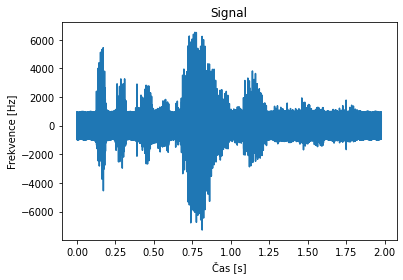

In [1]:
from scipy.io import wavfile
from scipy.signal import spectrogram
from scipy import signal as sgnl
import matplotlib.pyplot as plt
import numpy as np

# read the signal
fs, signal = wavfile.read('xkubra00.wav')

# get the lenght of the signal in samples
length_samples = signal.size
print ("Delka signalu ve vzorcich je", length_samples)

# get the length of the signal in seconds
length_seconds = signal.size / fs
print ("Delka signalu v sekundach je", length_seconds)

# get the maximum and minimum value of the signal
maximum = signal.max()
minimum = signal.min()
print ("Maximalni hodnota signalu je", maximum)
print ("Minimalni hodnota signalu je", minimum)

# plot the signal
time = np.linspace(0, signal.size / fs, num = signal.size)
plt.plot(time, signal)
plt.gca().set_xlabel('Čas [s]')
plt.gca().set_ylabel('Frekvence [Hz]')
plt.gca().set_title('Signal')
plt.show()

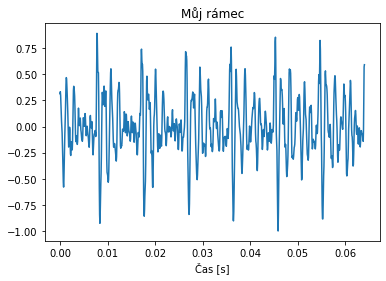

In [2]:
# ustredneni signalu
mean_value = sum(signal) / len(signal)
ustredneny_signal = signal - mean_value

# normalization of the signal
normalized_signal = ustredneny_signal / abs(ustredneny_signal).max()

# cutting the signal on separate frames
left_limit = 0
right_limit = 1024
current_frame = normalized_signal[left_limit : right_limit]
frames = np.empty([1024, (normalized_signal.size // 512) - 1])

for column in range((normalized_signal.size // 512) - 1):
    current_frame = normalized_signal[left_limit : right_limit]
    
    for row in range(1024):
        frames[row][column] = current_frame[row]
    left_limit += 512
    right_limit += 512

# found the frame I like
my_frame = frames[:, 24]
time = np.linspace(0, my_frame.size / fs, num = my_frame.size)
plt.plot(time, my_frame)
plt.gca().set_xlabel('Čas [s]')
plt.gca().set_title('Můj rámec')
plt.show()

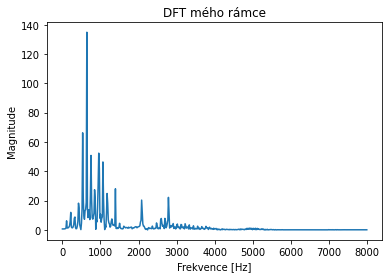

In [3]:
# function for dft using vector and matrix
def dft(signal, N):
    n = np.arange(N)
    k = n.reshape((N, 1))
    matrix = np.exp(-2j * np.pi * n * k / N)
    dft = np.dot(matrix, signal)
    return dft

# produce dft of my frame
dft_my_frame = abs(dft(my_frame, 1024))[0:512]
x_axis = np.linspace(0, fs / 2, num = dft_my_frame.size)
plt.plot(x_axis, dft_my_frame)
plt.gca().set_ylabel('Magnitude')
plt.gca().set_xlabel('Frekvence [Hz]')
plt.gca().set_title('DFT mého rámce')
plt.show()

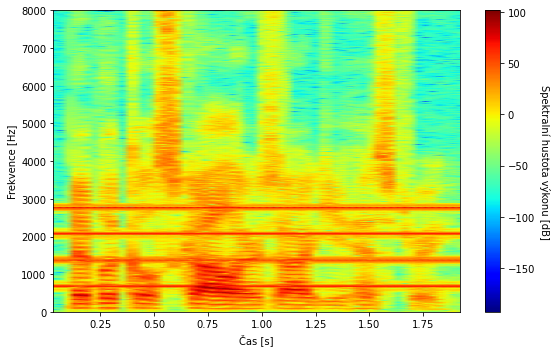

In [4]:
# spectrogram
f, t, sgr = spectrogram(signal, fs, nperseg = 1024, noverlap = 512)

sgr_log = 10 * np.log10(abs(sgr)**2 + 1e-20) 

plt.figure(figsize = (8, 5))
plt.pcolormesh(t, f, sgr_log, shading = "gouraud", cmap = "jet")
plt.gca().set_xlabel('Čas [s]')
plt.gca().set_ylabel('Frekvence [Hz]')
cbar = plt.colorbar()
cbar.set_label('Spektralní hustota výkonu [dB]', rotation = 270, labelpad = 15)

plt.tight_layout()

In [5]:
# take the first frame without speech and produce dft
dft_frame = abs(dft(frames[:, 0], 1024))[0:512]

# get the positions with the biggest frequencies and calculate them
positions = np.sort(dft_frame.argsort()[-4:])
print(positions / 1024 * fs)

[ 687.5   1390.625 2078.125 2781.25 ]


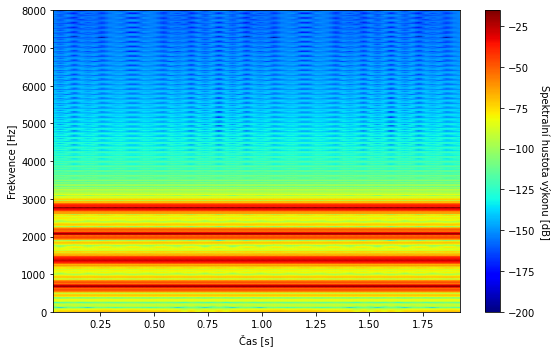

In [6]:
# generate 4 cos and get the output
time_step = length_seconds / length_samples
time_array = np.arange(0, length_seconds, time_step)

cos_1 = np.cos(2 * np.pi * 695 * time_array)
cos_2 = np.cos(2 * np.pi * 1390 * time_array)
cos_3 = np.cos(2 * np.pi * 2085 * time_array)
cos_4 = np.cos(2 * np.pi * 2780 * time_array)
output_cos = cos_1 + cos_2 + cos_3 + cos_4

wavfile.write("4cos.wav", fs, output_cos.astype(np.float32))

# spectrogram of 4 cos
fs_cos, signal_cos = wavfile.read('4cos.wav')

f_cos, t_cos, sgr_cos = spectrogram(signal_cos, fs_cos, nperseg = 1024, noverlap = 512)

sgr_log_cos = 10 * np.log10(sgr_cos + 1e-20) 

plt.figure(figsize = (8, 5))
plt.pcolormesh(t_cos, f_cos, sgr_log_cos, shading = "gouraud", cmap = "jet")
plt.gca().set_xlabel('Čas [s]')
plt.gca().set_ylabel('Frekvence [Hz]')
cbar = plt.colorbar()
cbar.set_label('Spektralní hustota výkonu [dB]', rotation = 270, labelpad = 15)

plt.tight_layout()

In [7]:
N1, Wn1 = sgnl.buttord( [620, 750], [670, 700], gpass = 3, gstop = 40, fs = fs / 2)
Wn1 = Wn1 / (0.5 * fs)
b1, a1 = sgnl.butter(N1, Wn1, btype = 'bandstop')

N2, Wn2 = sgnl.buttord( [1325, 1455], [1375, 1405], gpass = 3, gstop = 40, fs = fs / 2)
Wn2 = Wn2 / (0.5 * fs)
b2, a2 = sgnl.butter(N2, Wn2, btype = 'bandstop')

N3, Wn3 = sgnl.buttord( [2015, 2145], [2065, 2095], gpass = 3, gstop = 40, fs = fs / 2)
Wn3 = Wn3 / (0.5 * fs)
b3, a3 = sgnl.butter(N3, Wn3, btype = 'bandstop')

N4, Wn4 = sgnl.buttord( [2715, 2845], [2765, 2795], gpass = 3, gstop = 40, fs = fs / 2)
Wn4 = Wn4 / (0.5 * fs)
b4, a4 = sgnl.butter(N4, Wn4, btype = 'bandstop')

In [8]:
# impulse response
N_imp = 32
imp = [1, * np.zeros(N_imp - 1)] # jednotkovy impuls

Coefficients A of filter 1:  [  1.          -7.58887952  25.47018087 -49.3627974   60.41137554
 -47.80388211  23.88686159  -6.89237594   0.87954196]
Coefficients B of filter 1:  [  0.93783899  -7.23317869  24.67134116 -48.5907888   60.42959967
 -48.5907888   24.67134116  -7.23317869   0.93783899]
Impulse response of filter 1:


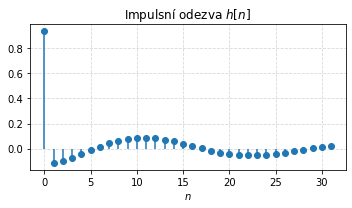

In [9]:
print("Coefficients A of filter 1: ", a1)
print("Coefficients B of filter 1: ", b1)
print("Impulse response of filter 1:")

h1 = sgnl.lfilter(b1, a1, imp)

plt.figure(figsize = (5, 3))
plt.stem(np.arange(N_imp), h1, basefmt = ' ')
plt.gca().set_xlabel('$n$')
plt.gca().set_title('Impulsní odezva $h[n]$')
plt.grid(alpha = 0.5, linestyle = '--')
plt.tight_layout()

Coefficients A of filter 2:  [  1.          -6.72581049  20.83355029 -38.53767276  46.43680955
 -37.28940041  19.50577401  -6.09319174   0.8766009 ]
Coefficients B of filter 2:  [  0.93626967  -6.4025588   20.1637294  -37.9204789   46.45273661
 -37.9204789   20.1637294   -6.4025588    0.93626967]
Impulse response of filter 2:


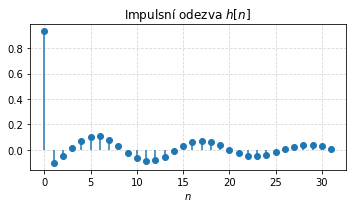

In [10]:
print("Coefficients A of filter 2: ", a2)
print("Coefficients B of filter 2: ", b2)
print("Impulse response of filter 2:")

h2 = sgnl.lfilter(b2, a2, imp)

plt.figure(figsize = (5, 3))
plt.stem(np.arange(N_imp), h2, basefmt = ' ')
plt.gca().set_xlabel('$n$')
plt.gca().set_title('Impulsní odezva $h[n]$')
plt.grid(alpha = 0.5, linestyle = '--')
plt.tight_layout()

Coefficients A of filter 3:  [  1.          -5.38723013  14.75124552 -25.40137255  29.95365082
 -24.56987902  13.80130557  -4.87530957   0.87535436]
Coefficients B of filter 3:  [  0.93560374  -5.12559139  14.27238853 -24.99130425  29.96557174
 -24.99130425  14.27238853  -5.12559139   0.93560374]
Impulse response of filter 3:


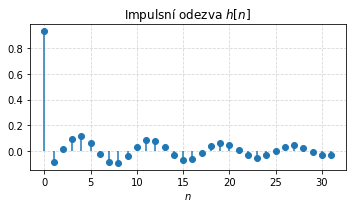

In [11]:
print("Coefficients A of filter 3: ", a3)
print("Coefficients B of filter 3: ", b3)
print("Impulse response of filter 3:")

h3 = sgnl.lfilter(b3, a3, imp)

plt.figure(figsize = (5, 3))
plt.stem(np.arange(N_imp), h3, basefmt = ' ')
plt.gca().set_xlabel('$n$')
plt.gca().set_title('Impulsní odezva $h[n]$')
plt.grid(alpha = 0.5, linestyle = '--')
plt.tight_layout()

Coefficients A of filter 4:  [  1.          -3.63140971   8.81449531 -13.53281967  15.86526976
 -13.09633292   8.25505929  -3.29121908   0.87708898]
Coefficients B of filter 4:  [  0.93653029  -3.45759694   8.53306321 -13.31829375  15.87272632
 -13.31829375   8.53306321  -3.45759694   0.93653029]
Impulse response of filter 4:


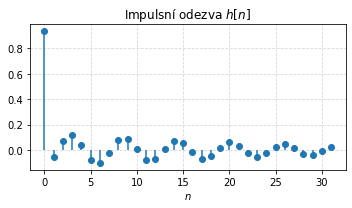

In [12]:
print("Coefficients A of filter 4: ", a4)
print("Coefficients B of filter 4: ", b4)
print("Impulse response of filter 4:")

h4 = sgnl.lfilter(b4, a4, imp)

plt.figure(figsize = (5, 3))
plt.stem(np.arange(N_imp), h4, basefmt = ' ')
plt.gca().set_xlabel('$n$')
plt.gca().set_title('Impulsní odezva $h[n]$')
plt.grid(alpha = 0.5, linestyle = '--')
plt.tight_layout()

Nuls and poles of filter 1:


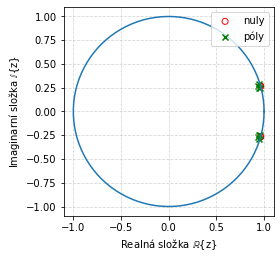

In [13]:
# nuls and poles of filter 1
print("Nuls and poles of filter 1:")
z1, p1, k1 = sgnl.tf2zpk(b1, a1)

plt.figure(figsize = (4, 3.7))

# jednotkova kruznice
ang = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(ang), np.sin(ang))

# nuly, poly
plt.scatter(np.real(z1), np.imag(z1), marker = 'o', facecolors = 'none', edgecolors = 'r', label = 'nuly')
plt.scatter(np.real(p1), np.imag(p1), marker = 'x', color = 'g', label = 'póly')

plt.gca().set_xlabel('Realná složka $\mathbb{R}\{$z$\}$')
plt.gca().set_ylabel('Imaginarní složka $\mathbb{I}\{$z$\}$')

plt.grid(alpha = 0.5, linestyle = '--')
plt.legend(loc = 'upper right')

plt.tight_layout()

Nuls and poles of filter 2:


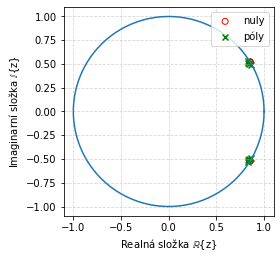

In [14]:
# nuls and poles of filter 2
print("Nuls and poles of filter 2:")
z2, p2, k2 = sgnl.tf2zpk(b2, a2)

plt.figure(figsize = (4, 3.7))

# jednotkova kruznice
ang = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(ang), np.sin(ang))

# nuly, poly
plt.scatter(np.real(z2), np.imag(z2), marker = 'o', facecolors = 'none', edgecolors = 'r', label = 'nuly')
plt.scatter(np.real(p2), np.imag(p2), marker = 'x', color = 'g', label = 'póly')

plt.gca().set_xlabel('Realná složka $\mathbb{R}\{$z$\}$')
plt.gca().set_ylabel('Imaginarní složka $\mathbb{I}\{$z$\}$')

plt.grid(alpha = 0.5, linestyle = '--')
plt.legend(loc = 'upper right')

plt.tight_layout()

Nuls and poles of filter 3:


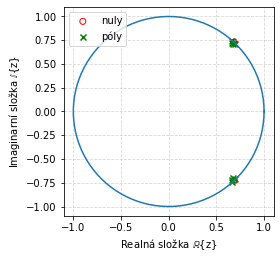

In [15]:
# nuls and poles of filter 3
print("Nuls and poles of filter 3:")
z3, p3, k3 = sgnl.tf2zpk(b3, a3)

plt.figure(figsize = (4, 3.7))

# jednotkova kruznice
ang = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(ang), np.sin(ang))

# nuly, poly
plt.scatter(np.real(z3), np.imag(z3), marker = 'o', facecolors = 'none', edgecolors = 'r', label = 'nuly')
plt.scatter(np.real(p3), np.imag(p3), marker = 'x', color = 'g', label = 'póly')

plt.gca().set_xlabel('Realná složka $\mathbb{R}\{$z$\}$')
plt.gca().set_ylabel('Imaginarní složka $\mathbb{I}\{$z$\}$')

plt.grid(alpha = 0.5, linestyle = '--')
plt.legend(loc = 'upper left')

plt.tight_layout()

Nuls and poles of filter 4:


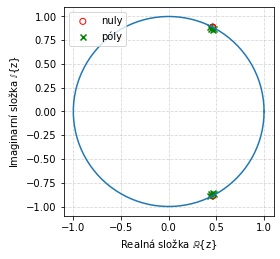

In [16]:
# nuls and poles of filter 1
print("Nuls and poles of filter 4:")
z4, p4, k4 = sgnl.tf2zpk(b4, a4)

plt.figure(figsize = (4, 3.7))

# jednotkova kruznice
ang = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(ang), np.sin(ang))

# nuly, poly
plt.scatter(np.real(z4), np.imag(z4), marker = 'o', facecolors = 'none', edgecolors = 'r', label = 'nuly')
plt.scatter(np.real(p4), np.imag(p4), marker = 'x', color = 'g', label = 'póly')

plt.gca().set_xlabel('Realná složka $\mathbb{R}\{$z$\}$')
plt.gca().set_ylabel('Imaginarní složka $\mathbb{I}\{$z$\}$')

plt.grid(alpha = 0.5, linestyle = '--')
plt.legend(loc = 'upper left')

plt.tight_layout()

Frequency response of filter 1:


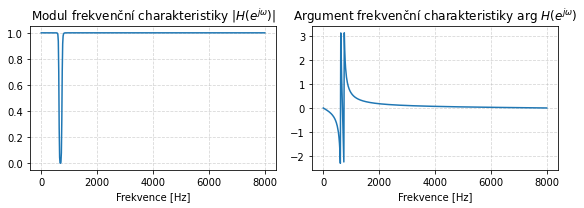

In [17]:
# frequency response of filter 1
print("Frequency response of filter 1:")
w1, H1 = sgnl.freqz(b1, a1)

_, ax = plt.subplots(1, 2, figsize = (8,3))

ax[0].plot(w1 / 2 / np.pi * fs, np.abs(H1))
ax[0].set_xlabel('Frekvence [Hz]')
ax[0].set_title('Modul frekvenční charakteristiky $|H(e^{j\omega})|$')

ax[1].plot(w1 / 2 / np.pi * fs, np.angle(H1))
ax[1].set_xlabel('Frekvence [Hz]')
ax[1].set_title('Argument frekvenční charakteristiky $\mathrm{arg}\ H(e^{j\omega})$')

for ax1 in ax:
    ax1.grid(alpha = 0.5, linestyle = '--')

plt.tight_layout()

Frequency response of filter 2:


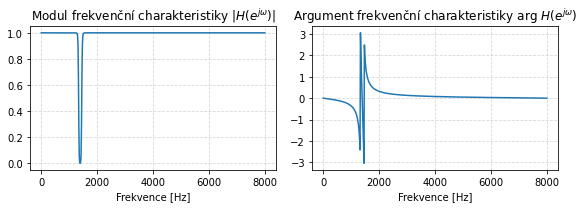

In [18]:
# frequency response of filter 2
print("Frequency response of filter 2:")
w2, H2 = sgnl.freqz(b2, a2)

_, ax = plt.subplots(1, 2, figsize = (8,3))

ax[0].plot(w2 / 2 / np.pi * fs, np.abs(H2))
ax[0].set_xlabel('Frekvence [Hz]')
ax[0].set_title('Modul frekvenční charakteristiky $|H(e^{j\omega})|$')

ax[1].plot(w2 / 2 / np.pi * fs, np.angle(H2))
ax[1].set_xlabel('Frekvence [Hz]')
ax[1].set_title('Argument frekvenční charakteristiky $\mathrm{arg}\ H(e^{j\omega})$')

for ax1 in ax:
    ax1.grid(alpha = 0.5, linestyle = '--')

plt.tight_layout()

Frequency response of filter 3:


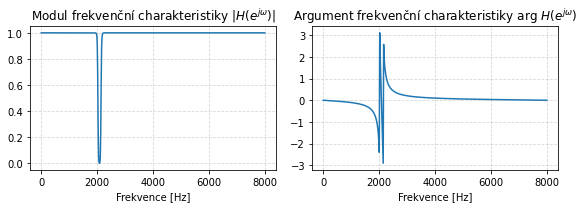

In [19]:
# frequency response of filter 3
print("Frequency response of filter 3:")
w3, H3 = sgnl.freqz(b3, a3)

_, ax = plt.subplots(1, 2, figsize = (8,3))

ax[0].plot(w3 / 2 / np.pi * fs, np.abs(H3))
ax[0].set_xlabel('Frekvence [Hz]')
ax[0].set_title('Modul frekvenční charakteristiky $|H(e^{j\omega})|$')

ax[1].plot(w3 / 2 / np.pi * fs, np.angle(H3))
ax[1].set_xlabel('Frekvence [Hz]')
ax[1].set_title('Argument frekvenční charakteristiky $\mathrm{arg}\ H(e^{j\omega})$')

for ax1 in ax:
    ax1.grid(alpha = 0.5, linestyle = '--')

plt.tight_layout()

Frequency response of filter 4:


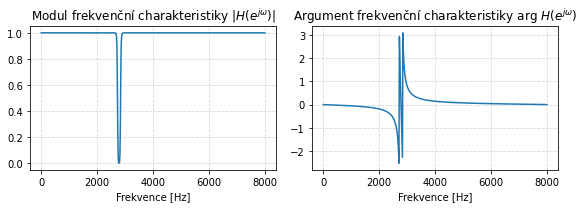

In [20]:
# frequency response of filter 4
print("Frequency response of filter 4:")
w4, H4 = sgnl.freqz(b4, a4)

_, ax = plt.subplots(1, 2, figsize = (8,3))

ax[0].plot(w4 / 2 / np.pi * fs, np.abs(H4))
ax[0].set_xlabel('Frekvence [Hz]')
ax[0].set_title('Modul frekvenční charakteristiky $|H(e^{j\omega})|$')

ax[1].plot(w4 / 2 / np.pi * fs, np.angle(H4))
ax[1].set_xlabel('Frekvence [Hz]')
ax[1].set_title('Argument frekvenční charakteristiky $\mathrm{arg}\ H(e^{j\omega})$')

for ax1 in ax:
    ax1.grid(alpha = 0.5, linestyle = '--')

plt.tight_layout()

In [21]:
# applying filters to the signal
signal_filt1 = sgnl.filtfilt(b1, a1, signal)
signal_filt2 = sgnl.filtfilt(b2, a2, signal_filt1)
signal_filt3 = sgnl.filtfilt(b3, a3, signal_filt2)
signal_filt4 = sgnl.filtfilt(b4, a4, signal_filt3)

# normalization
normalized_signal_filt = signal_filt4 / abs(signal_filt4).max()

wavfile.write("clean_bandstop.wav", fs, normalized_signal_filt.astype(np.float32))